In [170]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import glob
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [171]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [172]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [173]:
house_label = {
    "Gryffindor":0,
    "Hufflepuff":1,
    "Ravenclaw":2,
    "Slytherin":3     
}


In [174]:
full_dataset = pd.read_csv("pics_by_house64x.csv", index_col=0)

X = full_dataset.drop(columns=['house'])
X = torch.tensor(X.values).float()
y = full_dataset['house'].apply(lambda x: house_label[x])
y = torch.tensor(y.values)

train_size, test_size, validation_size = 0.8, 0.1, 0.1

In [177]:
full_dataset_size = len(full_dataset)
full_dataset_indices = list(full_dataset.index)

In [178]:
np.random.shuffle(full_dataset_indices)

In [180]:
val_split_index = int(np.floor(0.1 * full_dataset_size))

In [181]:
train_idx, val_idx = full_dataset_indices[val_split_index:], full_dataset_indices[:val_split_index]

In [182]:
from torch.utils.data.sampler import SubsetRandomSampler

In [183]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [158]:
### Test

In [184]:
from torch.utils.data import Dataset

class myDataset(Dataset):
    def __init__(self, samples,labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [185]:
data = myDataset(X, y)

In [162]:
class HouseClassifier(nn.Module):
    def __init__(self):
        super(HouseClassifier, self).__init__()
        self.block1 = self.conv_block(c_in=4, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=75, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.maxpool(x)
        x = self.lastcnn(x)
        return x
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        return seq_block

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
model = RpsClassifier()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()




optimizer = optim.Adam(model.parameters(), lr=0.005)

RpsClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 3, kernel_size=(75, 75), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [165]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc

In [167]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [168]:
from torch.utils.data import DataLoader

In [132]:
train_loader = DataLoader(dataset=myDataset, shuffle=False, batch_size=8, sampler=train_data)
val_loader = DataLoader(dataset=myDataset, shuffle=False, batch_size=1, sampler=validation_data)
test_loader = DataLoader(dataset=myDataset, shuffle=False, batch_size=1, sampler=test_data)

In [133]:
from tqdm import tqdm

In [134]:
print("Begin training.")
for e in tqdm(range(1, 11)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch).squeeze()
            y_val_pred = torch.unsqueeze(y_val_pred, 0)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += train_loss.item()
            val_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
#     print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f}
#     | Val Loss: {val_epoch_loss/len(val_loader):.5f} 
#           | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Begin training.


TypeError: Parameters to generic types must be types. Got tensor([128., 131., 136.,  ...,  91.,  83., 110.]).

In [135]:
import seaborn as sns


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

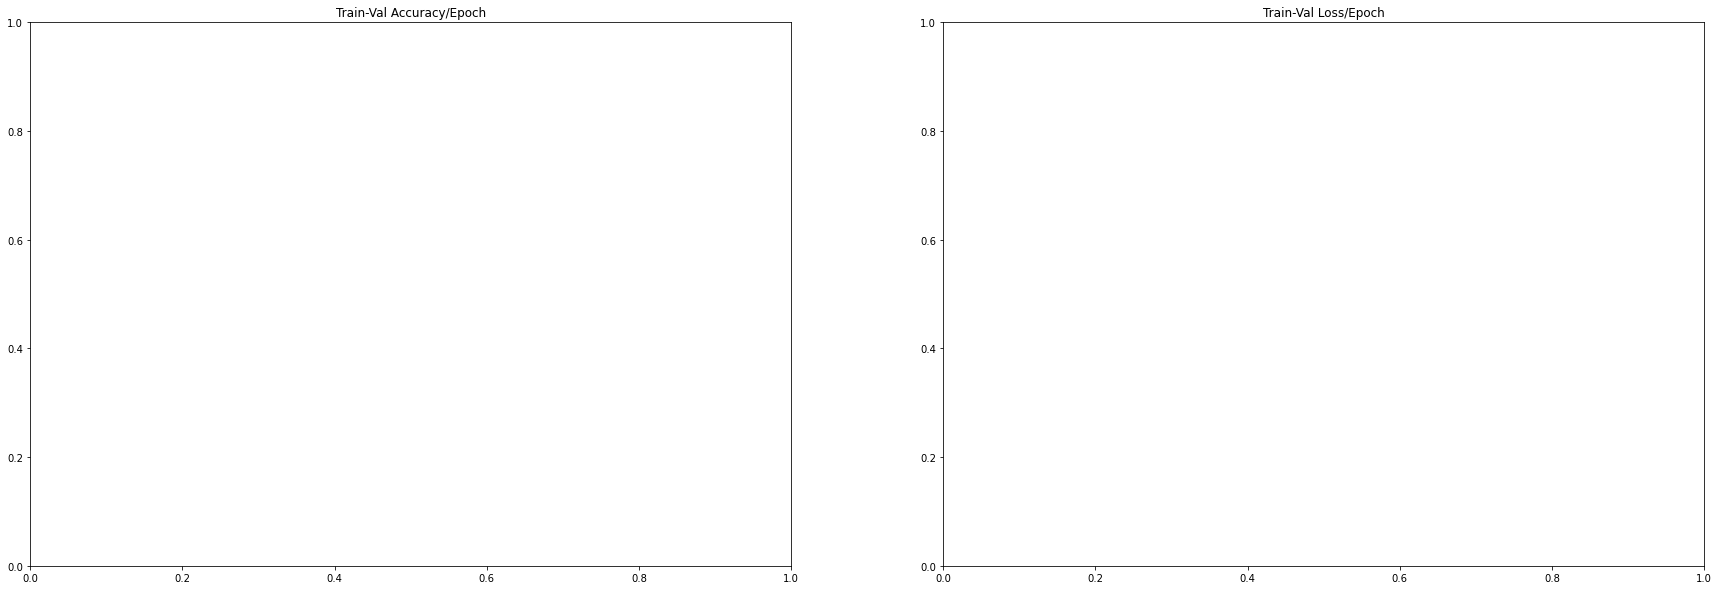

In [136]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [137]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|                                                                                           | 0/39 [00:00<?, ?it/s]


TypeError: Parameters to generic types must be types. Got tensor([125., 109., 110.,  ..., 160., 147., 126.]).

In [138]:
print(classification_report(y_true_list, y_pred_list))

NameError: name 'classification_report' is not defined

In [139]:
print(confusion_matrix(y_true_list, y_pred_list))

[]


In [140]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

NameError: name 'idx2class' is not defined